In [1]:
import sys
import os
sys.path.append(os.path.abspath("Pytorch/"))
sys.path.append(os.path.abspath("models/"))

In [2]:
from FBSNNs import *
from BlackScholesBarenblatt100D import *

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import time

M = 1  # number of trajectories (batch size)
N = 50  # number of time snapshots
D = 1 # number of dimensions
Mm = N ** (1/5)

layers = [D + 1] + 4 * [256] + [1]

Xi = np.array([1.0] * int(D))[None, :]
T = 1.0

"Available architectures"
mode = "Naisnet"  # FC and Naisnet are available
activation = "Sine"  # Sine, ReLU and Tanh are available
model = BlackScholesBarenblatt(Xi, T, M, N, D, Mm, layers, mode, activation)

n_iter = 2 * 10**4
lr = 1e-3

In [25]:
n_iter = 2 * 10**3
lr = 1e-6

In [26]:
tot = time.time()
print(model.device)
graph = model.train(n_iter, lr)
print("total time:", time.time() - tot, "s")

cuda:0
It: 21900, Loss: 4.739e-04, Y0: 1.232, Time: 0.16, Learning Rate: 1.000e-06
It: 22000, Loss: 1.873e-03, Y0: 1.232, Time: 15.65, Learning Rate: 1.000e-06
It: 22100, Loss: 2.956e-03, Y0: 1.232, Time: 15.75, Learning Rate: 1.000e-06
It: 22200, Loss: 8.568e-04, Y0: 1.232, Time: 15.70, Learning Rate: 1.000e-06
It: 22300, Loss: 1.739e-03, Y0: 1.233, Time: 15.84, Learning Rate: 1.000e-06
It: 22400, Loss: 8.001e-04, Y0: 1.233, Time: 15.72, Learning Rate: 1.000e-06
It: 22500, Loss: 6.258e-04, Y0: 1.232, Time: 15.55, Learning Rate: 1.000e-06
It: 22600, Loss: 4.008e-04, Y0: 1.233, Time: 15.75, Learning Rate: 1.000e-06
It: 22700, Loss: 1.057e-03, Y0: 1.233, Time: 15.73, Learning Rate: 1.000e-06
It: 22800, Loss: 6.292e-04, Y0: 1.234, Time: 15.64, Learning Rate: 1.000e-06
It: 22900, Loss: 1.245e-03, Y0: 1.234, Time: 15.71, Learning Rate: 1.000e-06
It: 23000, Loss: 2.329e-03, Y0: 1.233, Time: 15.79, Learning Rate: 1.000e-06
It: 23100, Loss: 2.405e-03, Y0: 1.234, Time: 15.59, Learning Rate: 1.0

In [27]:
t_test, W_test = model.fetch_minibatch()
X_pred, Y_pred = model.predict(Xi, t_test, W_test)

if type(t_test).__module__ != 'numpy':
    t_test = t_test.cpu().numpy()
if type(X_pred).__module__ != 'numpy':
    X_pred = X_pred.cpu().detach().numpy()
if type(Y_pred).__module__ != 'numpy':
    Y_pred = Y_pred.cpu().detach().numpy()

for i in range(100):
    t_test_i, W_test_i = model.fetch_minibatch()
    X_pred_i, Y_pred_i = model.predict(Xi, t_test_i, W_test_i)
    if type(X_pred_i).__module__ != 'numpy':
        X_pred_i = X_pred_i.cpu().detach().numpy()
    if type(Y_pred_i).__module__ != 'numpy':
        Y_pred_i = Y_pred_i.cpu().detach().numpy()
    if type(t_test_i).__module__ != 'numpy':
        t_test_i = t_test_i.cpu().numpy()
    X_pred = np.concatenate((X_pred, X_pred_i), axis=0)
    Y_pred = np.concatenate((Y_pred, Y_pred_i), axis=0)
    t_test = np.concatenate((t_test, t_test_i), axis=0)


In [28]:
Y_test = np.reshape(u_exact(T,np.reshape(t_test[0:101, :, :], [-1, 1]), np.reshape(X_pred[0:101, :, :], [-1, D])),
                    [101, -1, 1])

In [29]:
samples = 5

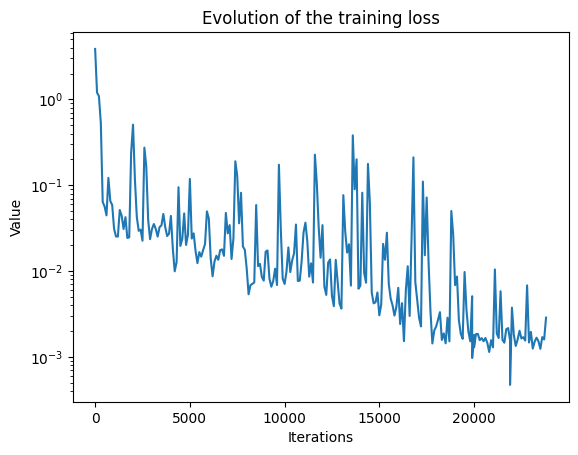

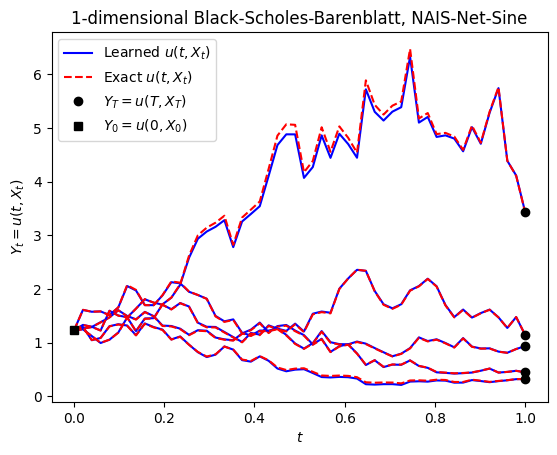

In [30]:
plt.figure()
plt.plot(graph[0], graph[1])
plt.xlabel('Iterations')
plt.ylabel('Value')
plt.yscale("log")
plt.title('Evolution of the training loss')

plt.figure()
plt.plot(t_test[0:1, :, 0].T, Y_pred[0:1, :, 0].T, 'b', label='Learned $u(t,X_t)$')
plt.plot(t_test[0:1, :, 0].T, Y_test[0:1, :, 0].T, 'r--', label='Exact $u(t,X_t)$')
plt.plot(t_test[0:1, -1, 0], Y_test[0:1, -1, 0], 'ko', label='$Y_T = u(T,X_T)$')

plt.plot(t_test[1:samples, :, 0].T, Y_pred[1:samples, :, 0].T, 'b')
plt.plot(t_test[1:samples, :, 0].T, Y_test[1:samples, :, 0].T, 'r--')
plt.plot(t_test[1:samples, -1, 0], Y_test[1:samples, -1, 0], 'ko')

plt.plot([0], Y_test[0, 0, 0], 'ks', label='$Y_0 = u(0,X_0)$')

plt.xlabel('$t$')
plt.ylabel('$Y_t = u(t,X_t)$')
plt.title(str(D) + '-dimensional Black-Scholes-Barenblatt, ' + model.mode + "-" + model.activation)
plt.legend()

plt.show()

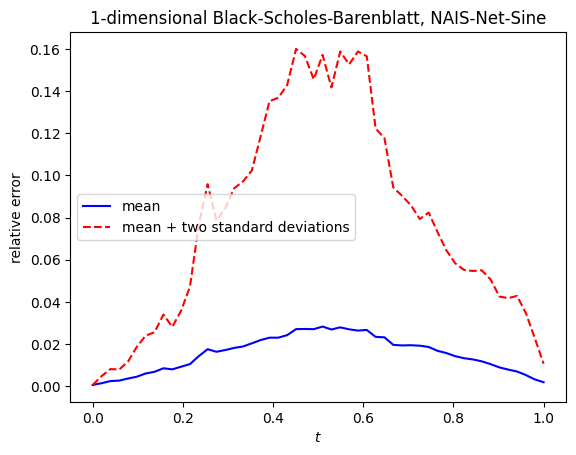

In [31]:
errors = np.sqrt((Y_test - Y_pred) ** 2 / Y_test ** 2)
mean_errors = np.mean(errors, 0)
std_errors = np.std(errors, 0)

plt.figure()
plt.plot(t_test[0, :, 0], mean_errors, 'b', label='mean')
plt.plot(t_test[0, :, 0], mean_errors + 2 * std_errors, 'r--', label='mean + two standard deviations')
plt.xlabel('$t$')
plt.ylabel('relative error')
plt.title(str(D) + '-dimensional Black-Scholes-Barenblatt, ' + model.mode + "-" + model.activation)
plt.legend()
plt.show()

In [8]:
model.save_model("models/BlackScholesBarenblattMLMC100D.pth")